# Ejecución en tiempo real del Predictor de series temporales (Forex)

A lo largo de este notebook, voy a describir la forma en la que se ejecuta el Predictor de series temporales basado en un modelo neuronal recurrente de células LSTM.


## 1 Descripción del problema

El problema fundamental es la adaptación en tiempo real de los datos recibidos del broker.

Para hacerlo de la forma más real posible, haremos lo siguiente:

- Inicialmente cargaré el histórico en un dataframe 'df'.
- En cada inicio de sesión (cada hora), recibiré un nuevo precio OHLCVS con su timestamp, por ejemplo con el formato: {DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOLUME,SPREAD}.
- Adaptaré ese nuevo registro y lo añadiré al dataframe 'df', descartando el primero, para mantenerlo siempre del mismo tamaño.
- Adaptaré los datos para el modelo neuronal, realizaré una predicción y de-normalizaré el resultado obteniendo los valores predichos.

### Carga de librerías

En primer lugar cargamos las librerías que vamos a utilizar. Las más significativas son:

- Numpy, Pandas, Scikit-Learn, Matplotlib & Seaborn
- Keras como librería ML sobre Tensorflow
- Talib como librería fintech
- MyUtils, una librería propia donde tengo un poco de todo: desde implementaciones neuronales, partición de pares de entrenamiento y test, visualización, backup de archivos en disco, etc...

In [13]:
import sys
sys.path.append('../..')

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls


####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import math

In [16]:
import common.MyUtils as utils
print('Ready!')

Ready!


### Obtención del histórico de precios OHLC

Para poder llevar a cabo la implementación del modelo, necesitamos una fuente de datos históricos con los precios OHLC del par euro-dólar.

El siguiente archivo ha sido extraido de Metatrader y en concreto del broker Darwinex. Contiene datos desde el año 2001 hasta el año 2018.

Es importante tener en cuenta lo siguiente a la hora de cargar los datos históricos en el dataframe de trabajo, ya que hay que 'limpiarlos':

- Puesto que trabajamos con datos horarios, hay que reindexar el dataframe de trabajo para que cada registro tenga una cadencia exacta de 1 hora. Esto nos permitirá descubrir todos los datos que falten (NaNs). Por ejemplo, en Forex, no hay cotización durante el fín de semana y por lo tanto todos esos datos están ausentes.
- A parte de las horas en las que no hay cotización, puede darse el caso de que el broker pierda algunos registros, por alguna razón técnica. En ese caso hay que estudiar los datos que faltan y rellenarlos de la mejor forma posible.
- Es necesario también visualizar los datos para verificar que no hay datos erróneos, que alteren la realidad. En caso de que existan, hay que corregirlos.

Para realizar la 'limpieza' anterior, en mi librería 'MyUtils' dispongo de la función 'load_hist' que permite eliminar entradas relativas a fines de semana y hace un relleno de los datos faltantes tipo 'fillna' con la última cotización conocida.


In [17]:
# Cargo el histórico en el dataframe 'df'
df = utils.load_hist('../csv_data/EURUSD_H1.csv', sep=';', remove_weekends=True)
# Marco la sección del dataframe que utilizo como histórico
df_hist = df[:int(df.shape[0]*0.9)].copy()
# Y la que utilizaré como datos en tiempo real
df_rt = df[int(df.shape[0]*0.9):].copy()

Deleting weekends...


In [18]:
df_hist.tail(1)

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2016-12-21,1.03855,1.04512,1.03822,1.03896,1.038755,1.040767,1.040213,0.00029,0,2,99986.0,917010000.0,50.0


In [19]:
df_rt.head(1)

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2016-12-21 01:00:00,1.03897,1.03978,1.03866,1.03903,1.039,1.039157,1.03911,0.00007,60,2,2345.0,1.808555e+09,13.0


Utilizo el índice 'i_rt' como índice del dato que se recibe (el siguiente cada vez).

In [20]:
# Inicio el contador de muestras
i_rt = -1

# creo las listas de resultado
high_list = []
low_list = []

# lista de los targets
target_high_list = []
target_low_list = []

# lista de error RMSE
rmse =[]

Añado un nuevo dato en formato json al dataframe 'df_hist'

In [21]:
i_rt += 1
# Simulo obtener un dato del broker (realmente cojo el siguiente en 'df_rt', sólo los campos que recibiría del broker)
new_ohlc = {'DATE': df_rt.iloc[i_rt].name.strftime(format='%Y.%m.%d'),
            'TIME': df_rt.iloc[i_rt].name.strftime(format='%H:%M:%S'),
            'OPEN': df_rt.iloc[i_rt]['OPEN'],
            'HIGH': df_rt.iloc[i_rt]['HIGH'],
            'LOW': df_rt.iloc[i_rt]['LOW'],
            'CLOSE': df_rt.iloc[i_rt]['CLOSE'],
            'TICKVOL': df_rt.iloc[i_rt]['TICKVOL'],
            'VOL': df_rt.iloc[i_rt]['VOL'],
            'SPREAD': df_rt.iloc[i_rt]['SPREAD']}

# Convierto la fecha a pandas.Timestamp
ts = new_ohlc['DATE'] + '  ' + new_ohlc['TIME'] 
new_ohlc['timestamp'] = pd.to_datetime(datetime.datetime.strptime(ts, '%Y.%m.%d %H:%M:%S'))

# Formo una nueva entrada para el dataframe 'df_hist'
new_ohlc['WEEKDAY'] = new_ohlc['timestamp'].dayofweek
new_ohlc['HHMM'] = new_ohlc['timestamp'].hour*60 +new_ohlc['timestamp'].minute
new_ohlc['OC2'] = (new_ohlc['CLOSE']+new_ohlc['OPEN'])/2
new_ohlc['HLC3'] = (new_ohlc['HIGH']+new_ohlc['LOW']+new_ohlc['CLOSE'])/3
new_ohlc['OHLC4'] = (new_ohlc['OPEN']+new_ohlc['HIGH']+new_ohlc['LOW']+new_ohlc['CLOSE'])/4
new_ohlc['CLOSE_DIFF'] = new_ohlc['CLOSE'] - df_hist.iloc[-1]['CLOSE']

# Añado la nueva entrada
df_hist.loc[new_ohlc['timestamp']] = [new_ohlc['OPEN'],
                                      new_ohlc['HIGH'],
                                      new_ohlc['LOW'],
                                      new_ohlc['CLOSE'],
                                      new_ohlc['OC2'],
                                      new_ohlc['HLC3'],
                                      new_ohlc['OHLC4'],
                                      new_ohlc['CLOSE_DIFF'],
                                      new_ohlc['HHMM'],
                                      new_ohlc['WEEKDAY'],
                                      new_ohlc['TICKVOL'],
                                      new_ohlc['VOL'],
                                      new_ohlc['SPREAD']]

# verifico el resultado
print(df_rt.iloc[i_rt])
df_hist.tail(2)

OPEN          1.038970e+00
HIGH          1.039780e+00
LOW           1.038660e+00
CLOSE         1.039030e+00
OC2           1.039000e+00
HLC3          1.039157e+00
OHLC4         1.039110e+00
CLOSE_DIFF    7.000000e-05
HHMM          6.000000e+01
WEEKDAY       2.000000e+00
TICKVOL       2.345000e+03
VOL           1.808555e+09
SPREAD        1.300000e+01
Name: 2016-12-21 01:00:00, dtype: float64


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2016-12-21 00:00:00,1.03855,1.04512,1.03822,1.03896,1.038755,1.040767,1.040213,0.00029,0.0,2.0,99986.0,9.170100e+08,50.0
2016-12-21 01:00:00,1.03897,1.03978,1.03866,1.03903,1.039000,1.039157,1.039110,0.00007,60.0,2.0,2345.0,1.808555e+09,13.0


Incluyo los indicadores técnicos

In [22]:
# Incluyo los indicadores técnicos más representativos y visualizo todas las columnas del nuevo dataframe 'df'
df_ind = utils.add_indicators(df_hist, applied=['HIGH','LOW'], base_cols=['OPEN','HIGH','LOW','CLOSE','OC2','HLC3','OHLC4'])
print(df_ind.columns)
df_ind.tail(2)

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'OC2', 'HLC3', 'OHLC4',
       'IND_BB_UPPER_HIGH', 'IND_BB_MIDDLE_HIGH', 'IND_BB_LOWER_HIGH',
       'IND_BB_WIDTH_HIGH', 'IND_BB_PERCENT_HIGH', 'IND_BB_WIDTH_SMA4_HIGH',
       'IND_BB_WIDTH_SMA12_HIGH', 'IND_SMA4_HIGH', 'IND_SMA16_HIGH',
       'IND_SMA40_HIGH', 'IND_MACD_HIGH', 'IND_MACD_SIG_HIGH',
       'IND_MACD_HIST_HIGH', 'IND_RSI_HIGH', 'IND_APO_HIGH', 'IND_MOM_HIGH',
       'IND_ROCP_HIGH', 'IND_ROCR_HIGH', 'IND_BB_UPPER_LOW',
       'IND_BB_MIDDLE_LOW', 'IND_BB_LOWER_LOW', 'IND_BB_WIDTH_LOW',
       'IND_BB_PERCENT_LOW', 'IND_BB_WIDTH_SMA4_LOW', 'IND_BB_WIDTH_SMA12_LOW',
       'IND_SMA4_LOW', 'IND_SMA16_LOW', 'IND_SMA40_LOW', 'IND_MACD_LOW',
       'IND_MACD_SIG_LOW', 'IND_MACD_HIST_LOW', 'IND_RSI_LOW', 'IND_APO_LOW',
       'IND_MOM_LOW', 'IND_ROCP_LOW', 'IND_ROCR_LOW', 'IND_WILLR', 'IND_ATR',
       'IND_ATR_SMA4', 'IND_ATR_SMA12', 'IND_ADX', 'IND_ADXR', 'IND_CCI',
       'IND_SLOWK', 'IND_SLOWD'],
      dtype='object')


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ROCR_LOW,IND_WILLR,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD
2016-12-21 00:00:00,1.03855,1.04512,1.03822,1.03896,1.038755,1.040767,1.040213,1.042979,1.039739,1.036498,...,1.002927,-62.034240,0.002006,0.001784,0.001834,36.814462,39.375107,171.092587,22.353160,39.081012
2016-12-21 01:00:00,1.03897,1.03978,1.03866,1.03903,1.039000,1.039157,1.039110,1.042774,1.039648,1.036521,...,1.003187,-61.329305,0.001943,0.001823,0.001849,36.457175,39.713290,48.235491,9.599537,22.857879


Preparo las salidas a predecir. Lógicamente son valores que los predecirá el modelo, pero es necesario calcular los objetivos para obtener un scaler válido para el unscaling final

In [23]:
# Preparo las salidas para su normalización
df_ind['OUT_HIGH'] = df_ind.HIGH - df_ind.CLOSE.shift(1)
df_ind['OUT_LOW'] = df_ind.LOW - df_ind.CLOSE.shift(1)
df_ind.tail(2)

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD,OUT_HIGH,OUT_LOW
2016-12-21 00:00:00,1.03855,1.04512,1.03822,1.03896,1.038755,1.040767,1.040213,1.042979,1.039739,1.036498,...,0.002006,0.001784,0.001834,36.814462,39.375107,171.092587,22.353160,39.081012,0.00645,-0.00045
2016-12-21 01:00:00,1.03897,1.03978,1.03866,1.03903,1.039000,1.039157,1.039110,1.042774,1.039648,1.036521,...,0.001943,0.001823,0.001849,36.457175,39.713290,48.235491,9.599537,22.857879,0.00082,-0.00030


Adapto los datos para el modelo neuronal, sin borrar los NaNs.
Posteriormente, los NaNs en las salidas a predecir los cambio por 0.
Y finalmente elimino las filas con NaNs.

In [24]:
# Defino el formato del dataframe 'df_nn' que voy a obtener como proceso de adaptación. Es necesario definir las siguientes
# variables que se utilizarán a lo largo del desarrollo

# Número de salidas a predecir
num_outputs = 2

# Número de 'features' de entrada
num_inputs = len(df_ind.columns) - num_outputs

# Número de timesteps previos
n_in = 4

# Número de timesteps a futuro
n_out = 1

# Flag para eliminar NaNs del dataframe resultante tras aplicar la adaptación
dropnan = False

# Procesa la adaptación al dataframe 'df' y genera un nuevo dataframe 'df_nn'
df_nn = utils.series_to_supervised(df_ind, num_inputs, num_outputs, n_in, n_out, dropnan)

# Las últimas salidas serán NaNs que debo borrar. Sustituyéndolas por la media no genera problemas
df_nn['OUT_HIGH(t+1)'].fillna(df_nn['OUT_HIGH(t+1)'].describe()['mean'], inplace=True)
df_nn['OUT_LOW(t+1)'].fillna(df_nn['OUT_LOW(t+1)'].describe()['mean'], inplace=True)

# Elimino el resto
df_nn.dropna(inplace=True)

df_nn.tail(2)

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2016-12-21 00:00:00,1.03938,1.03950,1.03858,1.03883,1.039105,1.038970,1.039072,1.042279,1.039773,1.037266,...,0.002006,0.001784,0.001834,36.814462,39.375107,171.092587,22.353160,39.081012,0.000820,-0.000300
2016-12-21 01:00:00,1.03881,1.03923,1.03853,1.03892,1.038865,1.038893,1.038872,1.042094,1.039672,1.037250,...,0.001943,0.001823,0.001849,36.457175,39.713290,48.235491,9.599537,22.857879,0.001338,-0.001307


Normalizo los datos

In [25]:
#### Normalización de los datos sobre el datafram 'df_nn'. Genero un nuevo dataframe 'dfnorm'
dfnorm, scaler = utils.normalize_data(df_nn)
# Verifico los datos del nuevo dataframe generado
dfnorm.describe()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
count,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,...,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000,99966.000000
mean,0.055937,0.055399,0.057178,0.055927,0.057059,0.057250,0.057336,0.061124,0.059478,0.055132,...,-0.605744,-0.588048,-0.568791,-0.224661,-0.242492,0.001954,0.000557,0.000570,-0.546145,0.701551
std,0.431292,0.430666,0.431611,0.431178,0.431850,0.431759,0.431809,0.433542,0.434070,0.431064,...,0.168632,0.176053,0.187641,0.345540,0.330558,0.236837,0.458913,0.424271,0.064221,0.069056
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.235027,-0.235241,-0.233717,-0.235018,-0.234311,-0.233994,-0.233928,-0.230803,-0.234054,-0.235717,...,-0.715713,-0.702921,-0.690840,-0.490720,-0.492134,-0.171106,-0.376960,-0.342879,-0.578315,0.692934
50%,0.146924,0.146618,0.147790,0.146886,0.148294,0.148385,0.148545,0.153767,0.151838,0.145823,...,-0.631535,-0.614433,-0.596607,-0.279032,-0.294326,0.003966,0.005656,0.006316,-0.564591,0.720311
75%,0.350496,0.348703,0.353067,0.350307,0.352046,0.352205,0.352264,0.353872,0.355457,0.352109,...,-0.536284,-0.515665,-0.491667,-0.004797,-0.036190,0.174845,0.378135,0.345263,-0.537142,0.735479
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Cargo el modelo neuronal y realizo la predicción para la última muestra recibida

Next HIGH= 1.0398789342289976  Target_High=  1.04019
Next LOW=  1.035340815680772  Target_Low=  1.03893


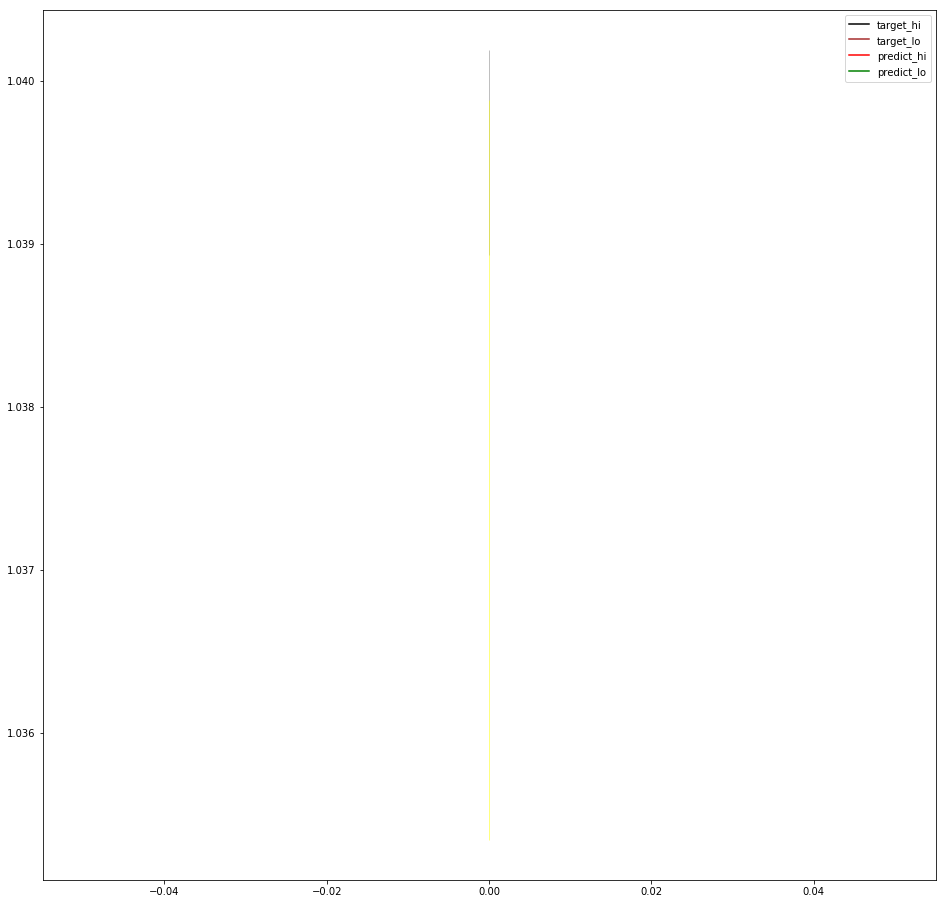

In [26]:
# Creo el modelo neuronal cargando el archivo de pesos
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'../hd5_data/weights_3.2.64.128.hd5')

# hago la predicción
x = dfnorm.values[-1,:(num_inputs*n_in)].reshape(1, n_in, num_inputs)
pred_scaled = model.predict(x, batch_size=1,verbose=0)
pred_scaled[0]

# deshago el scaling
xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), pred_scaled),axis=1)
xy_values = scaler.inverse_transform(xy_values)
pred_unscaled = xy_values[0, (x.shape[1]*x.shape[2]):]
pred_unscaled

# Actualizo las salidas predichas del dataframe normalizado
dfnorm.iloc[-1]['OUT_HIGH(t+1)'] = pred_scaled[0,0]
dfnorm.iloc[-1]['OUT_LOW(t+1)'] = pred_scaled[0,1]

# Obtengo los resultados finales
next_high = pred_unscaled[0] + df_nn.iloc[-1]['CLOSE(t)']
next_low = pred_unscaled[1] + df_nn.iloc[-1]['CLOSE(t)']
print('Next HIGH=', next_high, ' Target_High= ', df_rt.iloc[i_rt+1]['HIGH'])
print('Next LOW= ', next_low, ' Target_Low= ',df_rt.iloc[i_rt+1]['LOW'])

# Los añado a la lista de resultados
high_list.append(next_high)
low_list.append(next_low)

# guardo los targets
target_high_list.append(df_rt.iloc[i_rt+1]['HIGH'])
target_low_list.append(df_rt.iloc[i_rt+1]['LOW'])

# Visualizo el resultado acumulado
plt.figure(figsize=(16,16))
i,j=0,i_rt+1
x = np.arange(j-i)
y1 = np.asarray(target_high_list)[i:j]
y2 = np.asarray(target_low_list)[i:j]
y3 = np.asarray(high_list)[i:j]
y4 = np.asarray(low_list)[i:j]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])

### Ejecución step-by-step

La siguiente celda resume todo el notebook en una sola ejecución, para ir procesando muestras de una en una.

ValueError: x and y must have same first dimension, but have shapes (201,) and (200,)

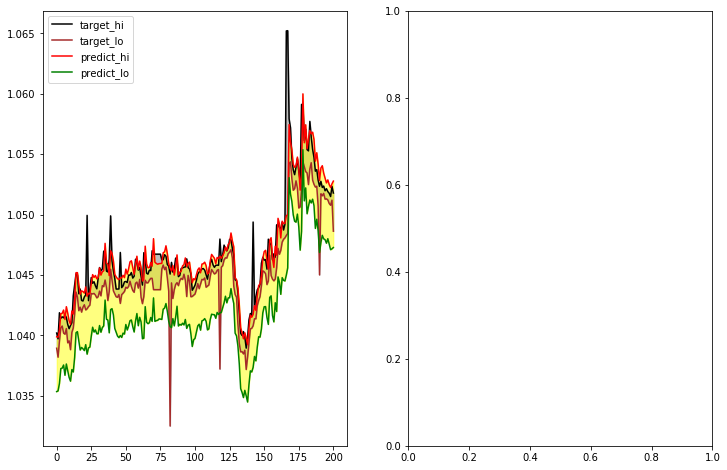

In [27]:
# Contador de incrementos consecutivos
_j = 200
for _i in range(_j):
  i_rt += 1
  # Simulo obtener un dato del broker (realmente cojo el siguiente en 'df_rt', sólo los campos que recibiría del broker)
  new_ohlc = {'DATE': df_rt.iloc[i_rt].name.strftime(format='%Y.%m.%d'),
              'TIME': df_rt.iloc[i_rt].name.strftime(format='%H:%M:%S'),
              'OPEN': df_rt.iloc[i_rt]['OPEN'],
              'HIGH': df_rt.iloc[i_rt]['HIGH'],
              'LOW': df_rt.iloc[i_rt]['LOW'],
              'CLOSE': df_rt.iloc[i_rt]['CLOSE'],
              'TICKVOL': df_rt.iloc[i_rt]['TICKVOL'],
              'VOL': df_rt.iloc[i_rt]['VOL'],
              'SPREAD': df_rt.iloc[i_rt]['SPREAD']}

  # Convierto la fecha a pandas.Timestamp
  ts = new_ohlc['DATE'] + '  ' + new_ohlc['TIME'] 
  new_ohlc['timestamp'] = pd.to_datetime(datetime.datetime.strptime(ts, '%Y.%m.%d %H:%M:%S'))

  # Formo una nueva entrada para el dataframe 'df_hist'
  new_ohlc['WEEKDAY'] = new_ohlc['timestamp'].dayofweek
  new_ohlc['HHMM'] = new_ohlc['timestamp'].hour*60 +new_ohlc['timestamp'].minute
  new_ohlc['OC2'] = (new_ohlc['CLOSE']+new_ohlc['OPEN'])/2
  new_ohlc['HLC3'] = (new_ohlc['HIGH']+new_ohlc['LOW']+new_ohlc['CLOSE'])/3
  new_ohlc['OHLC4'] = (new_ohlc['OPEN']+new_ohlc['HIGH']+new_ohlc['LOW']+new_ohlc['CLOSE'])/4
  new_ohlc['CLOSE_DIFF'] = new_ohlc['CLOSE'] - df_hist.iloc[-1]['CLOSE']

  # Añado la nueva entrada
  df_hist.loc[new_ohlc['timestamp']] = [new_ohlc['OPEN'],
                                        new_ohlc['HIGH'],
                                        new_ohlc['LOW'],
                                        new_ohlc['CLOSE'],
                                        new_ohlc['OC2'],
                                        new_ohlc['HLC3'],
                                        new_ohlc['OHLC4'],
                                        new_ohlc['CLOSE_DIFF'],
                                        new_ohlc['HHMM'],
                                        new_ohlc['WEEKDAY'],
                                        new_ohlc['TICKVOL'],
                                        new_ohlc['VOL'],
                                        new_ohlc['SPREAD']]

  # Incluyo los indicadores técnicos más representativos y visualizo todas las columnas del nuevo dataframe 'df'
  df_ind = utils.add_indicators(df_hist, applied=['HIGH','LOW'], base_cols=['OPEN','HIGH','LOW','CLOSE','OC2','HLC3','OHLC4'])

  # Preparo las salidas para su normalización
  df_ind['OUT_HIGH'] = df_ind.HIGH - df_ind.CLOSE.shift(1)
  df_ind['OUT_LOW'] = df_ind.LOW - df_ind.CLOSE.shift(1)

  # Defino el formato del dataframe 'df_nn' que voy a obtener como proceso de adaptación. Es necesario definir las siguientes
  # variables que se utilizarán a lo largo del desarrollo

  # Número de salidas a predecir
  num_outputs = 2

  # Número de 'features' de entrada
  num_inputs = len(df_ind.columns) - num_outputs

  # Número de timesteps previos
  n_in = 4

  # Número de timesteps a futuro
  n_out = 1

  # Flag para eliminar NaNs del dataframe resultante tras aplicar la adaptación
  dropnan = False

  # Procesa la adaptación al dataframe 'df' y genera un nuevo dataframe 'df_nn'
  df_nn = utils.series_to_supervised(df_ind, num_inputs, num_outputs, n_in, n_out, dropnan)

  # Las últimas salidas serán NaNs que debo borrar. Sustituyéndolas por la media no genera problemas
  df_nn['OUT_HIGH(t+1)'].fillna(df_nn['OUT_HIGH(t+1)'].describe()['mean'], inplace=True)
  df_nn['OUT_LOW(t+1)'].fillna(df_nn['OUT_LOW(t+1)'].describe()['mean'], inplace=True)

  # Elimino el resto
  df_nn.dropna(inplace=True)

  #### Normalización de los datos sobre el datafram 'df_nn'. Genero un nuevo dataframe 'dfnorm'
  dfnorm, scaler = utils.normalize_data(df_nn)

  # Creo el modelo neuronal cargando el archivo de pesos
  model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'../hd5_data/weights_3.2.64.128.hd5')

  # hago la predicción
  x = dfnorm.values[-1,:(num_inputs*n_in)].reshape(1, n_in, num_inputs)
  pred_scaled = model.predict(x, batch_size=1,verbose=0)
  pred_scaled[0]

  # deshago el scaling
  xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), pred_scaled),axis=1)
  xy_values = scaler.inverse_transform(xy_values)
  pred_unscaled = xy_values[0, (x.shape[1]*x.shape[2]):]
  pred_unscaled

  # Actualizo las salidas predichas del dataframe normalizado
  dfnorm.iloc[-1]['OUT_HIGH(t+1)'] = pred_scaled[0,0]
  dfnorm.iloc[-1]['OUT_LOW(t+1)'] = pred_scaled[0,1]

  # Obtengo los resultados finales
  next_high = pred_unscaled[0] + df_nn.iloc[-1]['CLOSE(t)']
  next_low = pred_unscaled[1] + df_nn.iloc[-1]['CLOSE(t)']
  if _j == 1:
    print('Next HIGH=', next_high, ' Target_High= ', df_rt.iloc[i_rt+1]['HIGH'])
    print('Next LOW= ', next_low, ' Target_Low= ',df_rt.iloc[i_rt+1]['LOW'])    

  # Los añado a la lista de resultados
  high_list.append(next_high)
  low_list.append(next_low)

  # guardo los targets
  target_high_list.append(df_rt.iloc[i_rt+1]['HIGH'])
  target_low_list.append(df_rt.iloc[i_rt+1]['LOW'])
  
  # guardo el error acumulado
  rmse_val = math.sqrt(sk.mean_squared_error([df_rt.iloc[i_rt+1]['HIGH'], df_rt.iloc[i_rt+1]['LOW']], [next_high, next_low], multioutput = 'uniform_average'))
  rmse.append(rmse_val)

# Visualizo el resultado acumulado
plt.figure(figsize=(12,8))
y1 = np.asarray(target_high_list)
y2 = np.asarray(target_low_list)
y3 = np.asarray(high_list)
y4 = np.asarray(low_list)
x = np.arange(len(target_high_list))
plt.subplot(1,2,1)
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
plt.subplot(1,2,2)
plt.plot(x, np.asarray(rmse), color='r')
plt.legend(['RMSE'])